In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from tqdm import tqdm_notebook

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
# default parameters
batch_size = 64  # input batch size
image_size = 64  # height / width of input image to network
nz = 100 # size of latent z vector
ngf = 32
ndf = 32
niter = 25 # number of epochs
lr = 0.0002 # learning rate
beta1 = 0.5 # beta1 for adam
outf = 'output_images'
workers = 2
ngpu = 1
nc = 3 # number of channels
netG_weights = '' # pre-defined model for generator
netD_weights = '' # pre-defined model for discriminator

In [4]:
if not os.path.exists(outf):
    os.makedirs(outf)

In [5]:
path_to_data = '/efs/data/CIFAR'
%time dataset = dset.CIFAR10(root=path_to_data, download=True, \
                            transform=transforms.Compose([ \
                            transforms.Scale(image_size), \
                            transforms.ToTensor(), \
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) \
                        ]))
%time raw_dataset = dset.CIFAR10(root=path_to_data, download=False)

Files already downloaded and verified
CPU times: user 796 ms, sys: 300 ms, total: 1.1 s
Wall time: 1.19 s
CPU times: user 456 ms, sys: 232 ms, total: 688 ms
Wall time: 741 ms


In [6]:
%time cat_idx = [i for i, img in enumerate(dataset) if img[1] == 3]
%time cat_dataset = [dataset[i] for i in cat_idx]
%time cat_raw_dataset = [raw_dataset[i] for i in cat_idx]

CPU times: user 12 s, sys: 64 ms, total: 12.1 s
Wall time: 12.1 s
CPU times: user 1.24 s, sys: 44 ms, total: 1.28 s
Wall time: 1.28 s
CPU times: user 260 ms, sys: 12 ms, total: 272 ms
Wall time: 259 ms


In [7]:
dataloader = torch.utils.data.DataLoader(cat_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [8]:
# cust weights initialization called on generator and discriminator networks
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [9]:
# generator network
class _netG(nn.Module):
    def __init__(self, ngpu):
        super(_netG, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution                                                                                                                                                                               
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4                                                                                                                                                                                        
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8                                                                                                                                                                                        
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16                                                                                                                                                                                      
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32                                                                                                                                                                                        
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32                                                                                                                                                                                                                    
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


In [10]:
# discriminator network
class _netD(nn.Module):
    def __init__(self, ngpu):
        super(_netD, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64                                                                                                                                                                                            
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32                                                                                                                                                                                        
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16                                                                                                                                                                                      
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8                                                                                                                                                                                        
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4                                                                                                                                                                                        
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


In [11]:
netG = _netG(ngpu)
netG.apply(weights_init)
if netG_weights != '':
    netG.load_state_dict(torch.load(netG_weights))
print(netG)

_netG (
  (main): Sequential (
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU (inplace)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU (inplace)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU (inplace)
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU (inplace)
    (12): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh ()
  )
)


In [12]:
netD = _netD(ngpu)
netD.apply(weights_init)
if netD_weights != '':
    netD.load_state_dict(torch.load(netD_weights))
print(netD)

_netD (
  (main): Sequential (
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU (0.2, inplace)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (4): LeakyReLU (0.2, inplace)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (7): LeakyReLU (0.2, inplace)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (10): LeakyReLU (0.2, inplace)
    (11): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid ()
  )
)


In [13]:
criterion = nn.BCELoss()

In [14]:
# define tensors
input = torch.FloatTensor(batch_size, 3, image_size, image_size)
noise = torch.FloatTensor(batch_size, nz, 1, 1)
fixed_noise = Variable(torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1))
label = torch.FloatTensor(batch_size)
real_label = 1
fake_label = 0

In [15]:
# switch to cuda if on GPU
if torch.cuda.is_available():
    print('cuda enabled')
    netD.cuda()
    netG.cuda()
    criterion.cuda()
    input, label = input.cuda(), label.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

cuda enabled


In [16]:
# setup optimizer                                                                                                                                                                                                                                 
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [17]:
# test sample
test_dataloader = torch.utils.data.DataLoader(cat_dataset, batch_size=1,
                                              shuffle=False, num_workers=1)
test_data_iter = iter(test_dataloader)
img_id = 9
for _ in range(img_id+1):
    test_sample = next(test_data_iter)

In [18]:
def Unnormalize(img):
    return ((img*0.5+0.5)*255).astype(np.uint8) # using 0.5 for mean and std (as from Normalize call above)

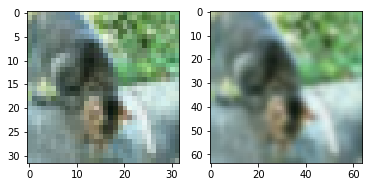

In [19]:
# plot original raw image against normalized image
plt.figure()
plt.subplot(121)
plt.imshow(np.asarray(cat_raw_dataset[img_id][0]))
plt.subplot(122)
plt.imshow(Unnormalize(test_sample[0].numpy()[0].transpose(1,2,0)))

In [20]:
# single pass though networks
netD.zero_grad()
real_cpu, _ = test_sample
batch_size = real_cpu.size(0)
if torch.cuda.is_available():
    real_cpu = real_cpu.cuda()
input.resize_as_(real_cpu).copy_(real_cpu)
label.resize_(batch_size).fill_(real_label)
inputv = Variable(input)
labelv = Variable(label)

In [21]:
output = netD(inputv)
errD_real = criterion(output, labelv)
errD_real.backward()
D_x = output.data.mean()

In [22]:
print(fixed_noise.size())
fake = netG(fixed_noise)
print(fake.size())

torch.Size([64, 100, 1, 1])
torch.Size([64, 3, 64, 64])


In [23]:
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################                                                                                                                                                                                                              
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))                                                                                                                                                                             
        ###########################                                                                                                                                                                                                               
        # train with real                                                                                                                                                                                                                         
        netD.zero_grad()
        real_cpu, _ = data
        batch_size = real_cpu.size(0)
        if torch.cuda.is_available():
            real_cpu = real_cpu.cuda()
        input.resize_as_(real_cpu).copy_(real_cpu)
        label.resize_(batch_size).fill_(real_label)
        inputv = Variable(input)
        labelv = Variable(label)

        output = netD(inputv)
        errD_real = criterion(output, labelv)
        errD_real.backward()
        D_x = output.data.mean()

        # train with fake                                                                                                                                                                                                                         
        noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = netG(noisev)
        labelv = Variable(label.fill_(fake_label))
        output = netD(fake.detach())
        errD_fake = criterion(output, labelv)
        errD_fake.backward()
        D_G_z1 = output.data.mean()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################                                                                                                                                                                                                              
        # (2) Update G network: maximize log(D(G(z)))                                                                                                                                                                                             
        ###########################                                                                                                                                                                                                               
        netG.zero_grad()
        labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost                                                                                                                                                     
        output = netD(fake)
        errG = criterion(output, labelv)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.data[0], errG.data[0], D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf,
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.data,
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)

    # do checkpointing                                                                                                                                                                                                                            
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))

[0/25][0/79] Loss_D: 1.5453 Loss_G: 2.4096 D(x): 0.5283 D(G(z)): 0.5429 / 0.1045
[0/25][1/79] Loss_D: 1.2950 Loss_G: 2.3445 D(x): 0.5258 D(G(z)): 0.4032 / 0.1154
[0/25][2/79] Loss_D: 1.1288 Loss_G: 2.3723 D(x): 0.6039 D(G(z)): 0.4110 / 0.1103
[0/25][3/79] Loss_D: 0.9703 Loss_G: 2.5692 D(x): 0.6471 D(G(z)): 0.3698 / 0.0883
[0/25][4/79] Loss_D: 0.7985 Loss_G: 2.9328 D(x): 0.7545 D(G(z)): 0.3624 / 0.0672
[0/25][5/79] Loss_D: 0.7876 Loss_G: 3.1075 D(x): 0.7368 D(G(z)): 0.3348 / 0.0562
[0/25][6/79] Loss_D: 0.7124 Loss_G: 3.1788 D(x): 0.7372 D(G(z)): 0.2845 / 0.0491
[0/25][7/79] Loss_D: 0.7920 Loss_G: 3.3055 D(x): 0.7849 D(G(z)): 0.3819 / 0.0446
[0/25][8/79] Loss_D: 0.7892 Loss_G: 3.4928 D(x): 0.7258 D(G(z)): 0.3173 / 0.0363
[0/25][9/79] Loss_D: 0.6415 Loss_G: 3.7976 D(x): 0.7845 D(G(z)): 0.3001 / 0.0274
[0/25][10/79] Loss_D: 0.6704 Loss_G: 3.7814 D(x): 0.7284 D(G(z)): 0.2585 / 0.0284
[0/25][11/79] Loss_D: 0.8130 Loss_G: 3.7310 D(x): 0.6963 D(G(z)): 0.2826 / 0.0286
[0/25][12/79] Loss_D: 0.63

[1/25][22/79] Loss_D: 0.0475 Loss_G: 6.9686 D(x): 0.9769 D(G(z)): 0.0218 / 0.0010
[1/25][23/79] Loss_D: 0.0379 Loss_G: 7.3382 D(x): 0.9861 D(G(z)): 0.0234 / 0.0007
[1/25][24/79] Loss_D: 0.0272 Loss_G: 7.2811 D(x): 0.9877 D(G(z)): 0.0145 / 0.0007
[1/25][25/79] Loss_D: 0.0360 Loss_G: 7.1494 D(x): 0.9833 D(G(z)): 0.0188 / 0.0008
[1/25][26/79] Loss_D: 0.0357 Loss_G: 7.6308 D(x): 0.9892 D(G(z)): 0.0243 / 0.0005
[1/25][27/79] Loss_D: 0.0289 Loss_G: 7.6458 D(x): 0.9886 D(G(z)): 0.0172 / 0.0005
[1/25][28/79] Loss_D: 0.0334 Loss_G: 7.5509 D(x): 0.9862 D(G(z)): 0.0192 / 0.0006
[1/25][29/79] Loss_D: 0.0435 Loss_G: 8.1426 D(x): 0.9856 D(G(z)): 0.0283 / 0.0003
[1/25][30/79] Loss_D: 0.0637 Loss_G: 7.5298 D(x): 0.9562 D(G(z)): 0.0143 / 0.0006
[1/25][31/79] Loss_D: 0.0410 Loss_G: 8.0805 D(x): 0.9881 D(G(z)): 0.0283 / 0.0004
[1/25][32/79] Loss_D: 0.0239 Loss_G: 7.8601 D(x): 0.9932 D(G(z)): 0.0168 / 0.0004
[1/25][33/79] Loss_D: 0.0275 Loss_G: 7.3644 D(x): 0.9878 D(G(z)): 0.0148 / 0.0007
[1/25][34/79] Lo

[2/25][43/79] Loss_D: 0.4486 Loss_G: 7.6073 D(x): 0.7436 D(G(z)): 0.0000 / 0.0237
[2/25][44/79] Loss_D: 0.3371 Loss_G: 8.2839 D(x): 0.9912 D(G(z)): 0.1201 / 0.0023
[2/25][45/79] Loss_D: 0.0570 Loss_G: 8.8893 D(x): 0.9961 D(G(z)): 0.0490 / 0.0016
[2/25][46/79] Loss_D: 0.1783 Loss_G: 6.8300 D(x): 0.9098 D(G(z)): 0.0164 / 0.0034
[2/25][47/79] Loss_D: 0.0913 Loss_G: 6.7255 D(x): 0.9831 D(G(z)): 0.0640 / 0.0019
[2/25][48/79] Loss_D: 0.0838 Loss_G: 7.3244 D(x): 0.9757 D(G(z)): 0.0555 / 0.0010
[2/25][49/79] Loss_D: 0.0708 Loss_G: 6.3750 D(x): 0.9622 D(G(z)): 0.0259 / 0.0023
[2/25][50/79] Loss_D: 0.1089 Loss_G: 6.9889 D(x): 0.9713 D(G(z)): 0.0676 / 0.0022
[2/25][51/79] Loss_D: 0.1443 Loss_G: 4.5774 D(x): 0.9119 D(G(z)): 0.0169 / 0.0224
[2/25][52/79] Loss_D: 0.2407 Loss_G: 10.5181 D(x): 0.9893 D(G(z)): 0.1952 / 0.0001
[2/25][53/79] Loss_D: 0.3330 Loss_G: 8.6090 D(x): 0.8083 D(G(z)): 0.0005 / 0.0004
[2/25][54/79] Loss_D: 0.0248 Loss_G: 6.3659 D(x): 0.9795 D(G(z)): 0.0023 / 0.0031
[2/25][55/79] L

[3/25][64/79] Loss_D: 0.5240 Loss_G: 7.9938 D(x): 0.6559 D(G(z)): 0.0006 / 0.0005
[3/25][65/79] Loss_D: 0.0708 Loss_G: 4.7982 D(x): 0.9554 D(G(z)): 0.0080 / 0.0143
[3/25][66/79] Loss_D: 0.5322 Loss_G: 10.4484 D(x): 0.9965 D(G(z)): 0.3601 / 0.0001
[3/25][67/79] Loss_D: 0.2728 Loss_G: 9.4410 D(x): 0.8064 D(G(z)): 0.0005 / 0.0004
[3/25][68/79] Loss_D: 0.1248 Loss_G: 7.1658 D(x): 0.8950 D(G(z)): 0.0016 / 0.0029
[3/25][69/79] Loss_D: 0.0411 Loss_G: 4.9659 D(x): 0.9800 D(G(z)): 0.0196 / 0.0151
[3/25][70/79] Loss_D: 0.2134 Loss_G: 6.4000 D(x): 0.9695 D(G(z)): 0.1454 / 0.0026
[3/25][71/79] Loss_D: 0.1189 Loss_G: 5.5947 D(x): 0.9104 D(G(z)): 0.0166 / 0.0069
[3/25][72/79] Loss_D: 0.0926 Loss_G: 4.9202 D(x): 0.9575 D(G(z)): 0.0443 / 0.0149
[3/25][73/79] Loss_D: 0.1122 Loss_G: 5.3887 D(x): 0.9805 D(G(z)): 0.0801 / 0.0068
[3/25][74/79] Loss_D: 0.0705 Loss_G: 5.4628 D(x): 0.9786 D(G(z)): 0.0464 / 0.0061
[3/25][75/79] Loss_D: 0.0905 Loss_G: 4.9287 D(x): 0.9519 D(G(z)): 0.0349 / 0.0096
[3/25][76/79] L

[5/25][7/79] Loss_D: 0.0773 Loss_G: 5.4928 D(x): 0.9749 D(G(z)): 0.0462 / 0.0096
[5/25][8/79] Loss_D: 0.1426 Loss_G: 6.5631 D(x): 0.9912 D(G(z)): 0.1104 / 0.0025
[5/25][9/79] Loss_D: 0.1234 Loss_G: 6.0977 D(x): 0.9302 D(G(z)): 0.0345 / 0.0032
[5/25][10/79] Loss_D: 0.1574 Loss_G: 4.9227 D(x): 0.9146 D(G(z)): 0.0523 / 0.0101
[5/25][11/79] Loss_D: 0.2174 Loss_G: 6.7809 D(x): 0.9541 D(G(z)): 0.1436 / 0.0015
[5/25][12/79] Loss_D: 0.2436 Loss_G: 5.0605 D(x): 0.8450 D(G(z)): 0.0291 / 0.0083
[5/25][13/79] Loss_D: 0.2290 Loss_G: 7.2415 D(x): 0.9706 D(G(z)): 0.1680 / 0.0010
[5/25][14/79] Loss_D: 0.1420 Loss_G: 6.0334 D(x): 0.8947 D(G(z)): 0.0210 / 0.0032
[5/25][15/79] Loss_D: 0.0541 Loss_G: 5.2302 D(x): 0.9724 D(G(z)): 0.0251 / 0.0070
[5/25][16/79] Loss_D: 0.2043 Loss_G: 5.2072 D(x): 0.9238 D(G(z)): 0.1076 / 0.0072
[5/25][17/79] Loss_D: 0.2255 Loss_G: 6.1948 D(x): 0.9146 D(G(z)): 0.1164 / 0.0030
[5/25][18/79] Loss_D: 0.1345 Loss_G: 5.3824 D(x): 0.9086 D(G(z)): 0.0288 / 0.0072
[5/25][19/79] Loss_

[6/25][31/79] Loss_D: 0.2941 Loss_G: 3.5248 D(x): 0.8603 D(G(z)): 0.1102 / 0.0424
[6/25][32/79] Loss_D: 0.2271 Loss_G: 4.0328 D(x): 0.9053 D(G(z)): 0.1059 / 0.0248
[6/25][33/79] Loss_D: 0.4623 Loss_G: 1.4804 D(x): 0.7359 D(G(z)): 0.0880 / 0.2570
[6/25][34/79] Loss_D: 0.7785 Loss_G: 8.8075 D(x): 0.9848 D(G(z)): 0.5065 / 0.0002
[6/25][35/79] Loss_D: 2.0565 Loss_G: 2.9057 D(x): 0.2185 D(G(z)): 0.0006 / 0.1017
[6/25][36/79] Loss_D: 0.4241 Loss_G: 3.4069 D(x): 0.9485 D(G(z)): 0.2687 / 0.0447
[6/25][37/79] Loss_D: 0.3989 Loss_G: 3.9669 D(x): 0.8499 D(G(z)): 0.1670 / 0.0305
[6/25][38/79] Loss_D: 0.7521 Loss_G: 2.4161 D(x): 0.7117 D(G(z)): 0.1797 / 0.1783
[6/25][39/79] Loss_D: 0.6466 Loss_G: 4.3492 D(x): 0.8568 D(G(z)): 0.3208 / 0.0200
[6/25][40/79] Loss_D: 0.3819 Loss_G: 3.3312 D(x): 0.7894 D(G(z)): 0.0962 / 0.0601
[6/25][41/79] Loss_D: 0.4897 Loss_G: 3.4457 D(x): 0.8281 D(G(z)): 0.2096 / 0.0521
[6/25][42/79] Loss_D: 0.4272 Loss_G: 3.7931 D(x): 0.8493 D(G(z)): 0.1767 / 0.0486
[6/25][43/79] Lo

[7/25][55/79] Loss_D: 0.4945 Loss_G: 5.8245 D(x): 0.8376 D(G(z)): 0.2302 / 0.0045
[7/25][56/79] Loss_D: 0.3647 Loss_G: 3.2015 D(x): 0.7487 D(G(z)): 0.0349 / 0.0610
[7/25][57/79] Loss_D: 0.3922 Loss_G: 4.8100 D(x): 0.9138 D(G(z)): 0.2387 / 0.0122
[7/25][58/79] Loss_D: 0.2850 Loss_G: 3.5013 D(x): 0.8133 D(G(z)): 0.0472 / 0.0505
[7/25][59/79] Loss_D: 0.5818 Loss_G: 4.5922 D(x): 0.8599 D(G(z)): 0.3117 / 0.0123
[7/25][60/79] Loss_D: 0.5409 Loss_G: 1.1242 D(x): 0.6723 D(G(z)): 0.0471 / 0.3855
[7/25][61/79] Loss_D: 1.1824 Loss_G: 10.8721 D(x): 0.9584 D(G(z)): 0.6198 / 0.0000
[7/25][62/79] Loss_D: 3.5619 Loss_G: 2.4306 D(x): 0.0567 D(G(z)): 0.0001 / 0.1380
[7/25][63/79] Loss_D: 0.6513 Loss_G: 6.3440 D(x): 0.9168 D(G(z)): 0.3781 / 0.0032
[7/25][64/79] Loss_D: 0.3962 Loss_G: 3.5504 D(x): 0.7157 D(G(z)): 0.0167 / 0.0592
[7/25][65/79] Loss_D: 0.4000 Loss_G: 2.6188 D(x): 0.8527 D(G(z)): 0.1784 / 0.0920
[7/25][66/79] Loss_D: 0.4797 Loss_G: 5.8071 D(x): 0.9605 D(G(z)): 0.3165 / 0.0057
[7/25][67/79] L

[9/25][0/79] Loss_D: 0.6764 Loss_G: 6.5261 D(x): 0.9622 D(G(z)): 0.3475 / 0.0023
[9/25][1/79] Loss_D: 0.3625 Loss_G: 4.9770 D(x): 0.7960 D(G(z)): 0.0696 / 0.0124
[9/25][2/79] Loss_D: 0.3637 Loss_G: 5.0330 D(x): 0.9001 D(G(z)): 0.1871 / 0.0113
[9/25][3/79] Loss_D: 0.5413 Loss_G: 5.3824 D(x): 0.8136 D(G(z)): 0.2380 / 0.0076
[9/25][4/79] Loss_D: 0.6131 Loss_G: 4.0993 D(x): 0.7225 D(G(z)): 0.1809 / 0.0284
[9/25][5/79] Loss_D: 0.5963 Loss_G: 6.1138 D(x): 0.8416 D(G(z)): 0.3003 / 0.0040
[9/25][6/79] Loss_D: 0.9606 Loss_G: 1.6708 D(x): 0.4764 D(G(z)): 0.0514 / 0.3043
[9/25][7/79] Loss_D: 1.5036 Loss_G: 8.7618 D(x): 0.9497 D(G(z)): 0.6689 / 0.0007
[9/25][8/79] Loss_D: 1.5181 Loss_G: 3.4036 D(x): 0.3461 D(G(z)): 0.0066 / 0.0881
[9/25][9/79] Loss_D: 0.4443 Loss_G: 2.9445 D(x): 0.9233 D(G(z)): 0.2157 / 0.1005
[9/25][10/79] Loss_D: 0.7176 Loss_G: 6.0112 D(x): 0.9769 D(G(z)): 0.4147 / 0.0051
[9/25][11/79] Loss_D: 0.8652 Loss_G: 3.1045 D(x): 0.5418 D(G(z)): 0.0243 / 0.0611
[9/25][12/79] Loss_D: 0.32

[10/25][22/79] Loss_D: 0.3471 Loss_G: 2.3882 D(x): 0.8555 D(G(z)): 0.0997 / 0.1996
[10/25][23/79] Loss_D: 1.5870 Loss_G: 7.6698 D(x): 0.9349 D(G(z)): 0.6791 / 0.0019
[10/25][24/79] Loss_D: 1.9416 Loss_G: 2.6903 D(x): 0.2699 D(G(z)): 0.0238 / 0.1454
[10/25][25/79] Loss_D: 1.1014 Loss_G: 5.6235 D(x): 0.8664 D(G(z)): 0.4840 / 0.0079
[10/25][26/79] Loss_D: 0.3788 Loss_G: 5.3006 D(x): 0.7794 D(G(z)): 0.0655 / 0.0086
[10/25][27/79] Loss_D: 0.3773 Loss_G: 3.5759 D(x): 0.7723 D(G(z)): 0.0762 / 0.0448
[10/25][28/79] Loss_D: 0.3464 Loss_G: 4.3708 D(x): 0.9457 D(G(z)): 0.2235 / 0.0201
[10/25][29/79] Loss_D: 0.8680 Loss_G: 3.3371 D(x): 0.6132 D(G(z)): 0.1947 / 0.0497
[10/25][30/79] Loss_D: 0.5462 Loss_G: 5.9691 D(x): 0.9241 D(G(z)): 0.3360 / 0.0034
[10/25][31/79] Loss_D: 0.5289 Loss_G: 4.4807 D(x): 0.6394 D(G(z)): 0.0260 / 0.0167
[10/25][32/79] Loss_D: 0.1623 Loss_G: 3.7689 D(x): 0.9203 D(G(z)): 0.0653 / 0.0384
[10/25][33/79] Loss_D: 0.2461 Loss_G: 3.9644 D(x): 0.9453 D(G(z)): 0.1589 / 0.0256
[10/

[11/25][43/79] Loss_D: 0.2977 Loss_G: 2.8409 D(x): 0.9486 D(G(z)): 0.1920 / 0.0839
[11/25][44/79] Loss_D: 0.4054 Loss_G: 3.6213 D(x): 0.8943 D(G(z)): 0.2229 / 0.0415
[11/25][45/79] Loss_D: 0.4292 Loss_G: 2.6461 D(x): 0.7565 D(G(z)): 0.0969 / 0.0951
[11/25][46/79] Loss_D: 0.5166 Loss_G: 2.7658 D(x): 0.8174 D(G(z)): 0.2210 / 0.0887
[11/25][47/79] Loss_D: 0.5495 Loss_G: 3.7212 D(x): 0.8356 D(G(z)): 0.2710 / 0.0367
[11/25][48/79] Loss_D: 0.6794 Loss_G: 1.5912 D(x): 0.5942 D(G(z)): 0.0630 / 0.2501
[11/25][49/79] Loss_D: 1.0312 Loss_G: 5.0606 D(x): 0.9109 D(G(z)): 0.5570 / 0.0102
[11/25][50/79] Loss_D: 1.4639 Loss_G: 1.9650 D(x): 0.3281 D(G(z)): 0.0193 / 0.1996
[11/25][51/79] Loss_D: 0.6873 Loss_G: 2.7703 D(x): 0.9015 D(G(z)): 0.3954 / 0.0931
[11/25][52/79] Loss_D: 0.3654 Loss_G: 3.6968 D(x): 0.8696 D(G(z)): 0.1795 / 0.0357
[11/25][53/79] Loss_D: 0.4547 Loss_G: 2.4243 D(x): 0.7305 D(G(z)): 0.0794 / 0.1180
[11/25][54/79] Loss_D: 0.2431 Loss_G: 2.8003 D(x): 0.9276 D(G(z)): 0.1443 / 0.0791
[11/

[12/25][64/79] Loss_D: 0.1478 Loss_G: 5.1018 D(x): 0.9903 D(G(z)): 0.1232 / 0.0092
[12/25][65/79] Loss_D: 0.7524 Loss_G: 1.5283 D(x): 0.5535 D(G(z)): 0.0220 / 0.2656
[12/25][66/79] Loss_D: 0.5473 Loss_G: 2.9669 D(x): 0.9424 D(G(z)): 0.3521 / 0.0631
[12/25][67/79] Loss_D: 0.4906 Loss_G: 7.0561 D(x): 0.9367 D(G(z)): 0.3120 / 0.0013
[12/25][68/79] Loss_D: 1.6976 Loss_G: 0.5917 D(x): 0.2560 D(G(z)): 0.0045 / 0.6115
[12/25][69/79] Loss_D: 1.3764 Loss_G: 2.2883 D(x): 0.9898 D(G(z)): 0.6664 / 0.1583
[12/25][70/79] Loss_D: 0.4951 Loss_G: 2.5916 D(x): 0.8009 D(G(z)): 0.2036 / 0.1054
[12/25][71/79] Loss_D: 0.6610 Loss_G: 4.0372 D(x): 0.7876 D(G(z)): 0.2978 / 0.0253
[12/25][72/79] Loss_D: 1.4187 Loss_G: 0.1570 D(x): 0.3419 D(G(z)): 0.1070 / 0.8636
[12/25][73/79] Loss_D: 2.7054 Loss_G: 7.6174 D(x): 0.9837 D(G(z)): 0.9035 / 0.0011
[12/25][74/79] Loss_D: 1.5090 Loss_G: 4.5945 D(x): 0.2968 D(G(z)): 0.0031 / 0.0202
[12/25][75/79] Loss_D: 0.8837 Loss_G: 0.6360 D(x): 0.5063 D(G(z)): 0.0728 / 0.5778
[12/

[14/25][7/79] Loss_D: 0.4845 Loss_G: 1.7214 D(x): 0.6948 D(G(z)): 0.0491 / 0.2470
[14/25][8/79] Loss_D: 1.1103 Loss_G: 6.8947 D(x): 0.9306 D(G(z)): 0.5782 / 0.0018
[14/25][9/79] Loss_D: 1.8164 Loss_G: 1.9181 D(x): 0.2319 D(G(z)): 0.0103 / 0.1979
[14/25][10/79] Loss_D: 0.9446 Loss_G: 3.6486 D(x): 0.8498 D(G(z)): 0.4757 / 0.0400
[14/25][11/79] Loss_D: 0.5471 Loss_G: 3.9310 D(x): 0.7775 D(G(z)): 0.2117 / 0.0304
[14/25][12/79] Loss_D: 1.0657 Loss_G: 0.8412 D(x): 0.4744 D(G(z)): 0.1164 / 0.4696
[14/25][13/79] Loss_D: 1.8916 Loss_G: 7.0602 D(x): 0.9674 D(G(z)): 0.8071 / 0.0013
[14/25][14/79] Loss_D: 1.6063 Loss_G: 3.3594 D(x): 0.2782 D(G(z)): 0.0063 / 0.0555
[14/25][15/79] Loss_D: 0.7406 Loss_G: 1.7817 D(x): 0.7425 D(G(z)): 0.2768 / 0.2310
[14/25][16/79] Loss_D: 1.2842 Loss_G: 4.5909 D(x): 0.8395 D(G(z)): 0.6227 / 0.0170
[14/25][17/79] Loss_D: 1.3862 Loss_G: 1.9115 D(x): 0.3720 D(G(z)): 0.0976 / 0.1872
[14/25][18/79] Loss_D: 1.0914 Loss_G: 3.0393 D(x): 0.8114 D(G(z)): 0.5437 / 0.0654
[14/25]

[15/25][28/79] Loss_D: 0.3637 Loss_G: 3.0359 D(x): 0.8444 D(G(z)): 0.1494 / 0.0657
[15/25][29/79] Loss_D: 0.2851 Loss_G: 5.4783 D(x): 0.9653 D(G(z)): 0.2069 / 0.0057
[15/25][30/79] Loss_D: 0.2555 Loss_G: 4.9990 D(x): 0.7986 D(G(z)): 0.0115 / 0.0106
[15/25][31/79] Loss_D: 0.3565 Loss_G: 2.1808 D(x): 0.7644 D(G(z)): 0.0400 / 0.1491
[15/25][32/79] Loss_D: 0.5486 Loss_G: 5.8529 D(x): 0.9554 D(G(z)): 0.3586 / 0.0048
[15/25][33/79] Loss_D: 0.0767 Loss_G: 6.4003 D(x): 0.9473 D(G(z)): 0.0190 / 0.0030
[15/25][34/79] Loss_D: 0.4407 Loss_G: 3.5583 D(x): 0.6784 D(G(z)): 0.0125 / 0.0416
[15/25][35/79] Loss_D: 0.0971 Loss_G: 2.9630 D(x): 0.9634 D(G(z)): 0.0564 / 0.0656
[15/25][36/79] Loss_D: 0.3006 Loss_G: 4.7233 D(x): 0.9701 D(G(z)): 0.2198 / 0.0123
[15/25][37/79] Loss_D: 0.0997 Loss_G: 5.3592 D(x): 0.9474 D(G(z)): 0.0427 / 0.0071
[15/25][38/79] Loss_D: 0.1320 Loss_G: 4.6275 D(x): 0.9044 D(G(z)): 0.0255 / 0.0156
[15/25][39/79] Loss_D: 0.1328 Loss_G: 3.9554 D(x): 0.9644 D(G(z)): 0.0873 / 0.0290
[15/

[16/25][49/79] Loss_D: 0.3801 Loss_G: 3.8721 D(x): 0.8664 D(G(z)): 0.1905 / 0.0301
[16/25][50/79] Loss_D: 0.3655 Loss_G: 3.4258 D(x): 0.8244 D(G(z)): 0.1292 / 0.0488
[16/25][51/79] Loss_D: 0.4984 Loss_G: 2.0370 D(x): 0.7363 D(G(z)): 0.1430 / 0.1628
[16/25][52/79] Loss_D: 0.6586 Loss_G: 3.1998 D(x): 0.8006 D(G(z)): 0.3144 / 0.0529
[16/25][53/79] Loss_D: 0.5819 Loss_G: 2.6516 D(x): 0.7217 D(G(z)): 0.1866 / 0.0964
[16/25][54/79] Loss_D: 0.4716 Loss_G: 2.7246 D(x): 0.7887 D(G(z)): 0.1866 / 0.0867
[16/25][55/79] Loss_D: 0.4049 Loss_G: 3.8348 D(x): 0.8631 D(G(z)): 0.2120 / 0.0273
[16/25][56/79] Loss_D: 0.4462 Loss_G: 2.7421 D(x): 0.7377 D(G(z)): 0.1048 / 0.0764
[16/25][57/79] Loss_D: 0.4052 Loss_G: 2.9112 D(x): 0.8244 D(G(z)): 0.1625 / 0.0745
[16/25][58/79] Loss_D: 0.5013 Loss_G: 4.8368 D(x): 0.9188 D(G(z)): 0.3110 / 0.0115
[16/25][59/79] Loss_D: 1.1225 Loss_G: 1.2470 D(x): 0.4020 D(G(z)): 0.0264 / 0.3348
[16/25][60/79] Loss_D: 0.8335 Loss_G: 5.5002 D(x): 0.9684 D(G(z)): 0.4939 / 0.0058
[16/

[17/25][70/79] Loss_D: 0.4569 Loss_G: 3.2388 D(x): 0.7781 D(G(z)): 0.1556 / 0.0545
[17/25][71/79] Loss_D: 0.3456 Loss_G: 3.1112 D(x): 0.8261 D(G(z)): 0.1232 / 0.0596
[17/25][72/79] Loss_D: 0.5501 Loss_G: 1.9836 D(x): 0.7101 D(G(z)): 0.1459 / 0.1725
[17/25][73/79] Loss_D: 0.6263 Loss_G: 3.7563 D(x): 0.8953 D(G(z)): 0.3697 / 0.0310
[17/25][74/79] Loss_D: 0.2967 Loss_G: 3.8983 D(x): 0.8009 D(G(z)): 0.0504 / 0.0289
[17/25][75/79] Loss_D: 0.2082 Loss_G: 3.2891 D(x): 0.9021 D(G(z)): 0.0928 / 0.0482
[17/25][76/79] Loss_D: 0.2759 Loss_G: 3.0172 D(x): 0.8813 D(G(z)): 0.1308 / 0.0651
[17/25][77/79] Loss_D: 0.5359 Loss_G: 2.0758 D(x): 0.7237 D(G(z)): 0.1482 / 0.1637
[17/25][78/79] Loss_D: 0.6124 Loss_G: 3.2345 D(x): 0.7787 D(G(z)): 0.2597 / 0.0432
[18/25][0/79] Loss_D: 0.3681 Loss_G: 4.1049 D(x): 0.9443 D(G(z)): 0.2496 / 0.0238
[18/25][1/79] Loss_D: 0.4374 Loss_G: 3.1694 D(x): 0.7129 D(G(z)): 0.0468 / 0.0615
[18/25][2/79] Loss_D: 0.2950 Loss_G: 3.3164 D(x): 0.9620 D(G(z)): 0.2148 / 0.0498
[18/25]

[19/25][13/79] Loss_D: 1.0500 Loss_G: 1.0736 D(x): 0.4660 D(G(z)): 0.1233 / 0.3895
[19/25][14/79] Loss_D: 0.9889 Loss_G: 4.1015 D(x): 0.9580 D(G(z)): 0.5619 / 0.0299
[19/25][15/79] Loss_D: 0.5586 Loss_G: 2.5144 D(x): 0.6482 D(G(z)): 0.0626 / 0.1141
[19/25][16/79] Loss_D: 0.7441 Loss_G: 1.5049 D(x): 0.6415 D(G(z)): 0.1971 / 0.2704
[19/25][17/79] Loss_D: 0.7648 Loss_G: 4.4436 D(x): 0.8987 D(G(z)): 0.4335 / 0.0183
[19/25][18/79] Loss_D: 0.6485 Loss_G: 2.5938 D(x): 0.6027 D(G(z)): 0.0572 / 0.1152
[19/25][19/79] Loss_D: 0.6273 Loss_G: 2.9990 D(x): 0.8961 D(G(z)): 0.3600 / 0.0678
[19/25][20/79] Loss_D: 0.4308 Loss_G: 4.3653 D(x): 0.8900 D(G(z)): 0.2399 / 0.0198
[19/25][21/79] Loss_D: 1.0396 Loss_G: 1.6117 D(x): 0.4322 D(G(z)): 0.0760 / 0.2529
[19/25][22/79] Loss_D: 0.8525 Loss_G: 3.8973 D(x): 0.9263 D(G(z)): 0.4820 / 0.0304
[19/25][23/79] Loss_D: 1.1635 Loss_G: 1.5689 D(x): 0.4035 D(G(z)): 0.1075 / 0.2536
[19/25][24/79] Loss_D: 0.6731 Loss_G: 2.6878 D(x): 0.8917 D(G(z)): 0.3862 / 0.0901
[19/

[20/25][34/79] Loss_D: 2.5424 Loss_G: 1.0724 D(x): 0.1079 D(G(z)): 0.0142 / 0.4022
[20/25][35/79] Loss_D: 1.6175 Loss_G: 5.2824 D(x): 0.9415 D(G(z)): 0.6991 / 0.0089
[20/25][36/79] Loss_D: 1.4073 Loss_G: 1.3257 D(x): 0.3290 D(G(z)): 0.0332 / 0.3212
[20/25][37/79] Loss_D: 1.4519 Loss_G: 3.0288 D(x): 0.8739 D(G(z)): 0.6571 / 0.0755
[20/25][38/79] Loss_D: 1.1366 Loss_G: 2.8229 D(x): 0.5404 D(G(z)): 0.2965 / 0.0872
[20/25][39/79] Loss_D: 1.0935 Loss_G: 1.0606 D(x): 0.4751 D(G(z)): 0.1448 / 0.4169
[20/25][40/79] Loss_D: 1.1743 Loss_G: 2.5539 D(x): 0.8055 D(G(z)): 0.5469 / 0.1041
[20/25][41/79] Loss_D: 0.6578 Loss_G: 2.4572 D(x): 0.6635 D(G(z)): 0.1661 / 0.1085
[20/25][42/79] Loss_D: 0.6691 Loss_G: 2.6062 D(x): 0.7937 D(G(z)): 0.3006 / 0.0998
[20/25][43/79] Loss_D: 0.5582 Loss_G: 2.3620 D(x): 0.7002 D(G(z)): 0.1183 / 0.1232
[20/25][44/79] Loss_D: 0.8855 Loss_G: 2.0901 D(x): 0.7586 D(G(z)): 0.3976 / 0.1563
[20/25][45/79] Loss_D: 0.7156 Loss_G: 2.5961 D(x): 0.7422 D(G(z)): 0.3011 / 0.0952
[20/

[21/25][55/79] Loss_D: 0.4378 Loss_G: 3.4845 D(x): 0.8073 D(G(z)): 0.1666 / 0.0434
[21/25][56/79] Loss_D: 0.6355 Loss_G: 1.9032 D(x): 0.6372 D(G(z)): 0.1143 / 0.1862
[21/25][57/79] Loss_D: 1.1388 Loss_G: 4.3053 D(x): 0.9218 D(G(z)): 0.5799 / 0.0261
[21/25][58/79] Loss_D: 1.2304 Loss_G: 1.1510 D(x): 0.3974 D(G(z)): 0.0596 / 0.4041
[21/25][59/79] Loss_D: 1.0751 Loss_G: 4.4885 D(x): 0.9576 D(G(z)): 0.5807 / 0.0205
[21/25][60/79] Loss_D: 0.6506 Loss_G: 3.5503 D(x): 0.6220 D(G(z)): 0.0938 / 0.0462
[21/25][61/79] Loss_D: 0.5187 Loss_G: 2.3466 D(x): 0.7429 D(G(z)): 0.1524 / 0.1285
[21/25][62/79] Loss_D: 0.8093 Loss_G: 3.9133 D(x): 0.8171 D(G(z)): 0.3914 / 0.0325
[21/25][63/79] Loss_D: 0.7560 Loss_G: 2.4582 D(x): 0.6277 D(G(z)): 0.1766 / 0.1253
[21/25][64/79] Loss_D: 1.3282 Loss_G: 1.4582 D(x): 0.5098 D(G(z)): 0.3862 / 0.2728
[21/25][65/79] Loss_D: 1.1513 Loss_G: 4.5298 D(x): 0.8352 D(G(z)): 0.5678 / 0.0170
[21/25][66/79] Loss_D: 1.1949 Loss_G: 1.8522 D(x): 0.3967 D(G(z)): 0.0549 / 0.2038
[21/

[22/25][76/79] Loss_D: 1.4021 Loss_G: 1.6657 D(x): 0.3238 D(G(z)): 0.0223 / 0.2531
[22/25][77/79] Loss_D: 0.7893 Loss_G: 4.2191 D(x): 0.9374 D(G(z)): 0.4700 / 0.0227
[22/25][78/79] Loss_D: 0.4532 Loss_G: 2.3157 D(x): 0.6715 D(G(z)): 0.0302 / 0.1176
[23/25][0/79] Loss_D: 0.9218 Loss_G: 4.1948 D(x): 0.9231 D(G(z)): 0.4864 / 0.0265
[23/25][1/79] Loss_D: 0.9403 Loss_G: 1.6424 D(x): 0.5235 D(G(z)): 0.0972 / 0.2562
[23/25][2/79] Loss_D: 0.9364 Loss_G: 2.9925 D(x): 0.8763 D(G(z)): 0.4558 / 0.0857
[23/25][3/79] Loss_D: 0.5282 Loss_G: 3.2571 D(x): 0.7750 D(G(z)): 0.1932 / 0.0582
[23/25][4/79] Loss_D: 0.3974 Loss_G: 3.1301 D(x): 0.8296 D(G(z)): 0.1664 / 0.0602
[23/25][5/79] Loss_D: 0.9842 Loss_G: 1.3906 D(x): 0.5337 D(G(z)): 0.1718 / 0.2864
[23/25][6/79] Loss_D: 1.0125 Loss_G: 4.1777 D(x): 0.8837 D(G(z)): 0.5459 / 0.0221
[23/25][7/79] Loss_D: 1.0688 Loss_G: 1.8949 D(x): 0.4646 D(G(z)): 0.1230 / 0.2106
[23/25][8/79] Loss_D: 0.7308 Loss_G: 2.3098 D(x): 0.7535 D(G(z)): 0.2828 / 0.1464
[23/25][9/79]

[24/25][19/79] Loss_D: 0.8865 Loss_G: 3.0315 D(x): 0.8901 D(G(z)): 0.4414 / 0.0711
[24/25][20/79] Loss_D: 0.8164 Loss_G: 1.7633 D(x): 0.5761 D(G(z)): 0.1437 / 0.2205
[24/25][21/79] Loss_D: 0.8900 Loss_G: 2.5906 D(x): 0.8018 D(G(z)): 0.4425 / 0.0899
[24/25][22/79] Loss_D: 1.0159 Loss_G: 2.5346 D(x): 0.6385 D(G(z)): 0.3451 / 0.0989
[24/25][23/79] Loss_D: 1.1413 Loss_G: 1.2475 D(x): 0.4789 D(G(z)): 0.1835 / 0.3581
[24/25][24/79] Loss_D: 1.0217 Loss_G: 3.8056 D(x): 0.8749 D(G(z)): 0.5022 / 0.0305
[24/25][25/79] Loss_D: 0.6005 Loss_G: 2.4334 D(x): 0.6614 D(G(z)): 0.1061 / 0.1256
[24/25][26/79] Loss_D: 0.5442 Loss_G: 3.2216 D(x): 0.8477 D(G(z)): 0.2691 / 0.0566
[24/25][27/79] Loss_D: 0.8271 Loss_G: 1.2739 D(x): 0.5987 D(G(z)): 0.1882 / 0.3144
[24/25][28/79] Loss_D: 0.8584 Loss_G: 4.4426 D(x): 0.9256 D(G(z)): 0.4989 / 0.0168
[24/25][29/79] Loss_D: 0.8754 Loss_G: 1.1367 D(x): 0.5018 D(G(z)): 0.0689 / 0.3572
[24/25][30/79] Loss_D: 0.9969 Loss_G: 4.7466 D(x): 0.8426 D(G(z)): 0.5077 / 0.0126
[24/

In [24]:
# run discriminator against image (real label = 1, fake label = 0)
# - test against real image first
test_input = Variable(test_sample[0])
if torch.cuda.is_available():
    test_input = test_input.cuda()
test_output = netD(test_input)
print('Real image score: ' + str(test_output.cpu().data.numpy()))

Real image score: [ 0.35653681]


Fake image score: [ 0.96723157]
Fake image score: [ 0.94586253]
Fake image score: [ 0.56714332]
Fake image score: [ 0.93029624]
Fake image score: [ 0.96043938]
Fake image score: [ 0.35109007]
Fake image score: [ 0.9952662]
Fake image score: [ 0.25494319]
Fake image score: [ 0.70637053]


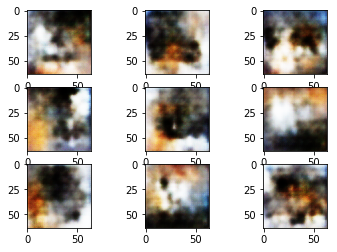

In [33]:
# - test against fake images
plt.figure()
for i in range(1,10):
    test_noise = torch.FloatTensor(1, nz, 1, 1).normal_(0,1)
    test_noisev = Variable(test_noise)
    if torch.cuda.is_available():
        test_noisev = test_noisev.cuda()
    test_fake_input = netG(test_noisev)
    test_fake_output = netD(test_fake_input)
    print('Fake image score: ' + str(test_fake_output.cpu().data.numpy()))
    plt.subplot(3, 3, i)
    plt.imshow(Unnormalize(test_fake_input.cpu().data.numpy()[0].transpose(1,2,0)))

In [34]:
fixed_noise_input = netG(fixed_noise[0].unsqueeze(0))
fixed_noise_output = netD(fixed_noise_input)
print(fixed_noise_output)

Variable containing:
 0.3689
[torch.cuda.FloatTensor of size 1 (GPU 0)]



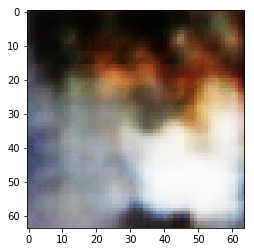

In [35]:
plt.imshow(Unnormalize(fixed_noise_input.cpu().data.numpy()[0].transpose(1,2,0)))